In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, BackupAndRestore, TerminateOnNaN, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import seaborn as sns   
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vibration_data = pl.read_csv(r'./vibration_data.csv')

print("Vibration dataset shape:", vibration_data.shape)

Vibration dataset shape: (93753, 1158)


In [55]:
train_data_numpy = vibration_data[1:,:].to_numpy()
true_labels = vibration_data[0, :].to_numpy() 

In [56]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(train_data_numpy)  
X_train, X_temp = train_test_split(X_scaled, test_size=0.2, random_state=42)
X_test, X_val = train_test_split(X_temp, test_size=0.5, random_state=42)

Model Settings

In [5]:
class_weighting = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(true_labels.reshape(-1)),
                                                  y=true_labels.reshape(-1))
epochs = 30
batch_size = 2048
class_weights = {0: class_weighting[0], 1: class_weighting[1]}

In [6]:
tf.keras.backend.clear_session()
input_dim = X_scaled.shape[1]

tensorboard = TensorBoard(log_dir='./logs', profile_batch='10,30')

backup = BackupAndRestore(backup_dir = "./backup")
 
terminate = TerminateOnNaN()

earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0, 
                              patience = 7, 
                              verbose = 1,
                              restore_best_weights=True)

checkpoint = ModelCheckpoint(r'./model.keras', # your path here
                             monitor='val_accuracy',     # Accuracy on the validation set
                             save_best_only=True,        # Save only the best model
                             verbose=1,
                             save_weights_only=False,
                             mode="auto", 
                             save_freq="epoch")    

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',  # Metric
                                            patience=2,             # Number of epochs with no improvement
                                            verbose=1,              # Log output
                                            factor=0.3,             # Factor by which the learning rate will be reduced
                                            min_lr=0.000001)

autoencoder = Sequential([
Input(shape=(input_dim,)),

Dense(1024, activation='relu'),
BatchNormalization(),
Dense(512, activation='relu'),
BatchNormalization(),
Dense(64, activation='relu'),

Dense(512, activation='relu'),
BatchNormalization(),
Dense(1024, activation='relu'),
BatchNormalization(),
Dropout(0.3),
Dense(input_dim, activation='softmax')
])

autoencoder.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2 = 0.999, epsilon=1e-07),
                    loss="mae",
                    metrics=['accuracy', 'precision', 'recall', 'auc'])

history = autoencoder.fit(X_train, X_train,
            epochs=epochs,
            batch_size=batch_size, 
            shuffle=True,
            verbose=1,
            class_weight = class_weights,
            validation_data=(X_val, X_val),
            callbacks=[tensorboard, backup, terminate, earlystopping, checkpoint, learning_rate_reduction])


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 276ms/step - accuracy: 7.2559e-04 - auc: 0.4949 - loss: 0.5019 - precision: 0.8421 - recall: 3.4170e-08 - val_accuracy: 1.0666e-04 - val_auc: 0.5000 - val_loss: 0.5017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 8.3377e-04 - auc: 0.5036 - loss: 0.5018 - precision: 0.6842 - recall: 3.2521e-08 - val_accuracy: 4.2662e-04 - val_auc: 0.5000 - val_loss: 0.5017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 7.3172e-04 - auc: 0.5080 - loss: 0.5018 - precision: 0.8421 - recall: 6.8269e-08 - val_accuracy: 6.3993e-04 - val_auc: 0.5000 - val_loss: 0.5017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 7.4362e-04 - auc: 0.5030 - loss: 0.5018 - precision: 0.8947 - recall: 9.8747e-08 - val_accuracy: 0.0013 - val_auc: 0.5000 - val_loss: 0.5017 - val

In [7]:
autoencoder.summary()
autoencoder.save('autoencoder.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     1,186,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1158)           │     1,186,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,494,548 (40.03 MB)

 Trainable params: 3,496,134 (13.34 MB)

 Non-trainable params: 6,144 (24.00 KB)

 Optimizer params: 6,992,270 (26.67 MB)

2930/2930 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
Optimal Threshold from ROC: 0.5154652077477588


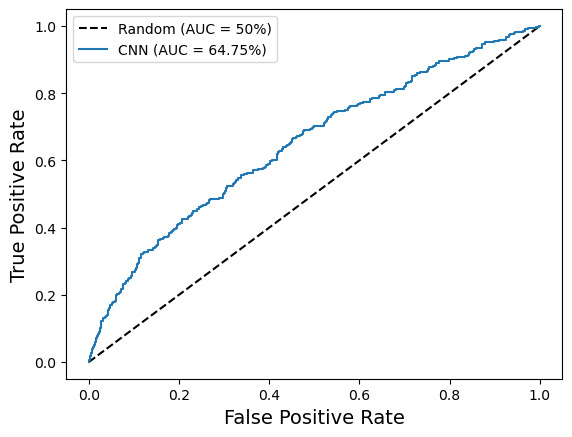

In [76]:
reconstructed_data = autoencoder.predict(X_scaled)

reconstruction_error = np.mean(np.abs(reconstructed_data - X_scaled), axis=0)

true_labels = true_labels.flatten()

fpr, tpr, thresholds = roc_curve(true_labels, reconstruction_error)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

auc_score = roc_auc_score(true_labels, reconstruction_error)
print(f"Optimal Threshold from ROC: {optimal_threshold}")

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc_score * 100))
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend(loc='best')
plt.show()

(1158, 2)


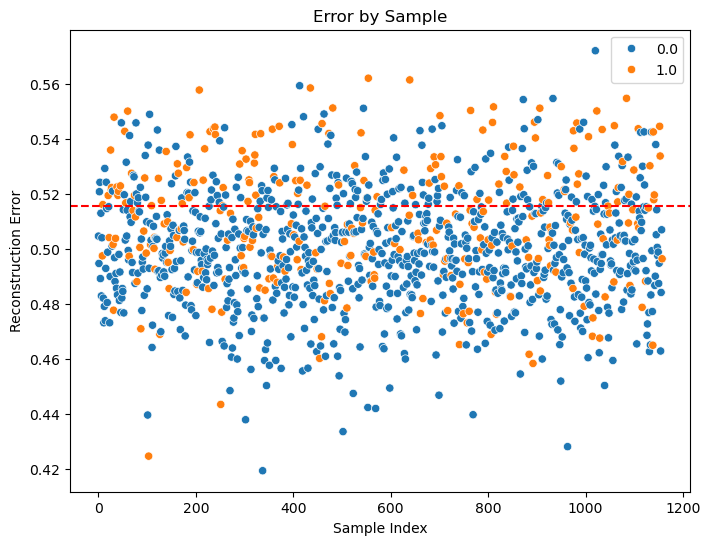

In [75]:
recons_df = pl.DataFrame({
    'error': reconstruction_error,
    'y_true': true_labels
}).to_pandas() 
temp = recons_df.reset_index(drop=True)
print(temp.shape)
plt.figure(figsize=(8,6))
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=optimal_threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Error by Sample')
plt.legend()
plt.show()

In [71]:
percentiles = np.arange(0, 90, 5)

results = []

for p in percentiles:
    threshold = np.percentile(reconstruction_error, p)
    
    predicted_anomalies = (recons_df['error'] > threshold).astype(int)
    
    precision = precision_score(true_labels, predicted_anomalies)
    recall = recall_score(true_labels, predicted_anomalies)
    f1 = f1_score(true_labels, predicted_anomalies)
    
    results.append({'Percentile': p, 'Threshold': threshold, 'Precision': precision, 'Recall': recall, 'F1': f1})

results_df = pl.DataFrame(results)
print(results_df)


shape: (18, 5)
┌────────────┬───────────┬───────────┬──────────┬──────────┐
│ Percentile ┆ Threshold ┆ Precision ┆ Recall   ┆ F1       │
│ ---        ┆ ---       ┆ ---       ┆ ---      ┆ ---      │
│ i64        ┆ f64       ┆ f64       ┆ f64      ┆ f64      │
╞════════════╪═══════════╪═══════════╪══════════╪══════════╡
│ 0          ┆ 0.419377  ┆ 0.253241  ┆ 1.0      ┆ 0.404138 │
│ 5          ┆ 0.465446  ┆ 0.26      ┆ 0.976109 ┆ 0.410625 │
│ 10         ┆ 0.474781  ┆ 0.267754  ┆ 0.952218 ┆ 0.417978 │
│ 15         ┆ 0.479629  ┆ 0.270325  ┆ 0.90785  ┆ 0.416601 │
│ 20         ┆ 0.484219  ┆ 0.280778  ┆ 0.887372 ┆ 0.426579 │
│ …          ┆ …         ┆ …         ┆ …        ┆ …        │
│ 65         ┆ 0.5093    ┆ 0.360494  ┆ 0.498294 ┆ 0.418338 │
│ 70         ┆ 0.512947  ┆ 0.387931  ┆ 0.460751 ┆ 0.421217 │
│ 75         ┆ 0.516386  ┆ 0.410345  ┆ 0.406143 ┆ 0.408233 │
│ 80         ┆ 0.519504  ┆ 0.435345  ┆ 0.34471  ┆ 0.384762 │
│ 85         ┆ 0.523567  ┆ 0.471264  ┆ 0.279863 ┆ 0.351178 │
└────────

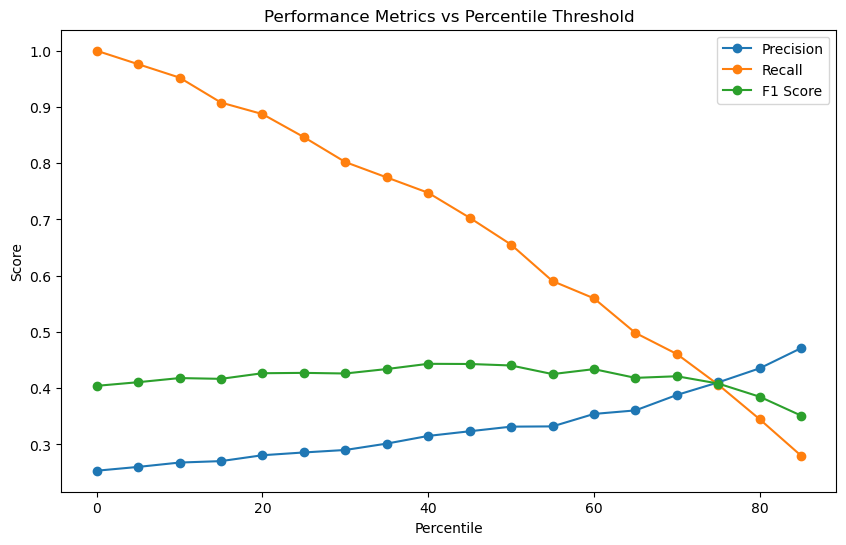

In [72]:
percentiles = results_df['Percentile'].to_numpy()
precision = results_df['Precision'].to_numpy()
recall = results_df['Recall'].to_numpy()
f1 = results_df['F1'].to_numpy()

plt.figure(figsize=(10,6))
plt.plot(percentiles, precision, label='Precision', marker='o')
plt.plot(percentiles, recall, label='Recall', marker='o')
plt.plot(percentiles, f1, label='F1 Score', marker='o')

plt.xlabel('Percentile')
plt.ylabel('Score')
plt.title('Performance Metrics vs Percentile Threshold')
plt.legend()
plt.show()


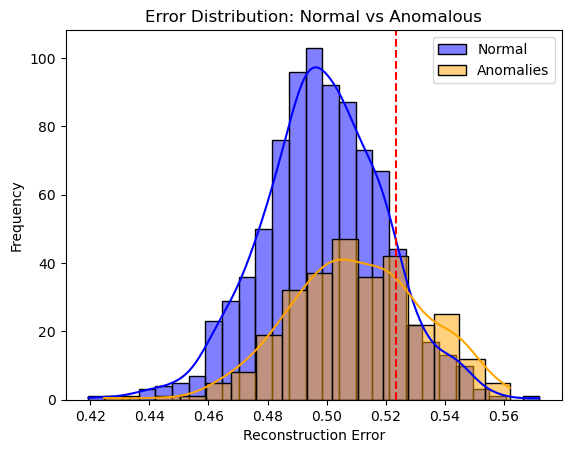

In [73]:
sns.histplot(reconstruction_error[true_labels == 0], color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[true_labels == 1], color='orange', label='Anomalies', kde=True)
plt.axvline(x=threshold, color='red', linestyle='--')
plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution: Normal vs Anomalous')
plt.show()


In [74]:
predicted_labels = reconstruction_error > threshold
comparison = np.vstack((predicted_labels, true_labels))

print("Comparison of identifiers, predicted labels, and actual answers:")
print(comparison)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Accuracy of the autoencoder predictions:, {accuracy:.3f}")

Comparison of identifiers, predicted labels, and actual answers:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Accuracy of the autoencoder predictions:, 0.738


In [69]:
df_res = pl.DataFrame({
    "Predicted Labels": comparison[0,:].astype(int),
    "Actual Answers": comparison[1,:].astype(int)
})
df_res.write_csv("results.csv")

In [70]:
df_res_test = pl.read_csv("results.csv")
df_res_test.describe()

statistic,Predicted Labels,Actual Answers
str,f64,f64
"""count""",1158.0,1158.0
"""null_count""",0.0,0.0
"""mean""",0.150259,0.253022
"""std""",0.35748,0.434932
"""min""",0.0,0.0
"""25%""",0.0,0.0
"""50%""",0.0,0.0
"""75%""",0.0,1.0
"""max""",1.0,1.0


In [17]:
# !tensorboard --logdir ./logs

293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


ValueError: Found input variables with inconsistent numbers of samples: [1158, 10855092]

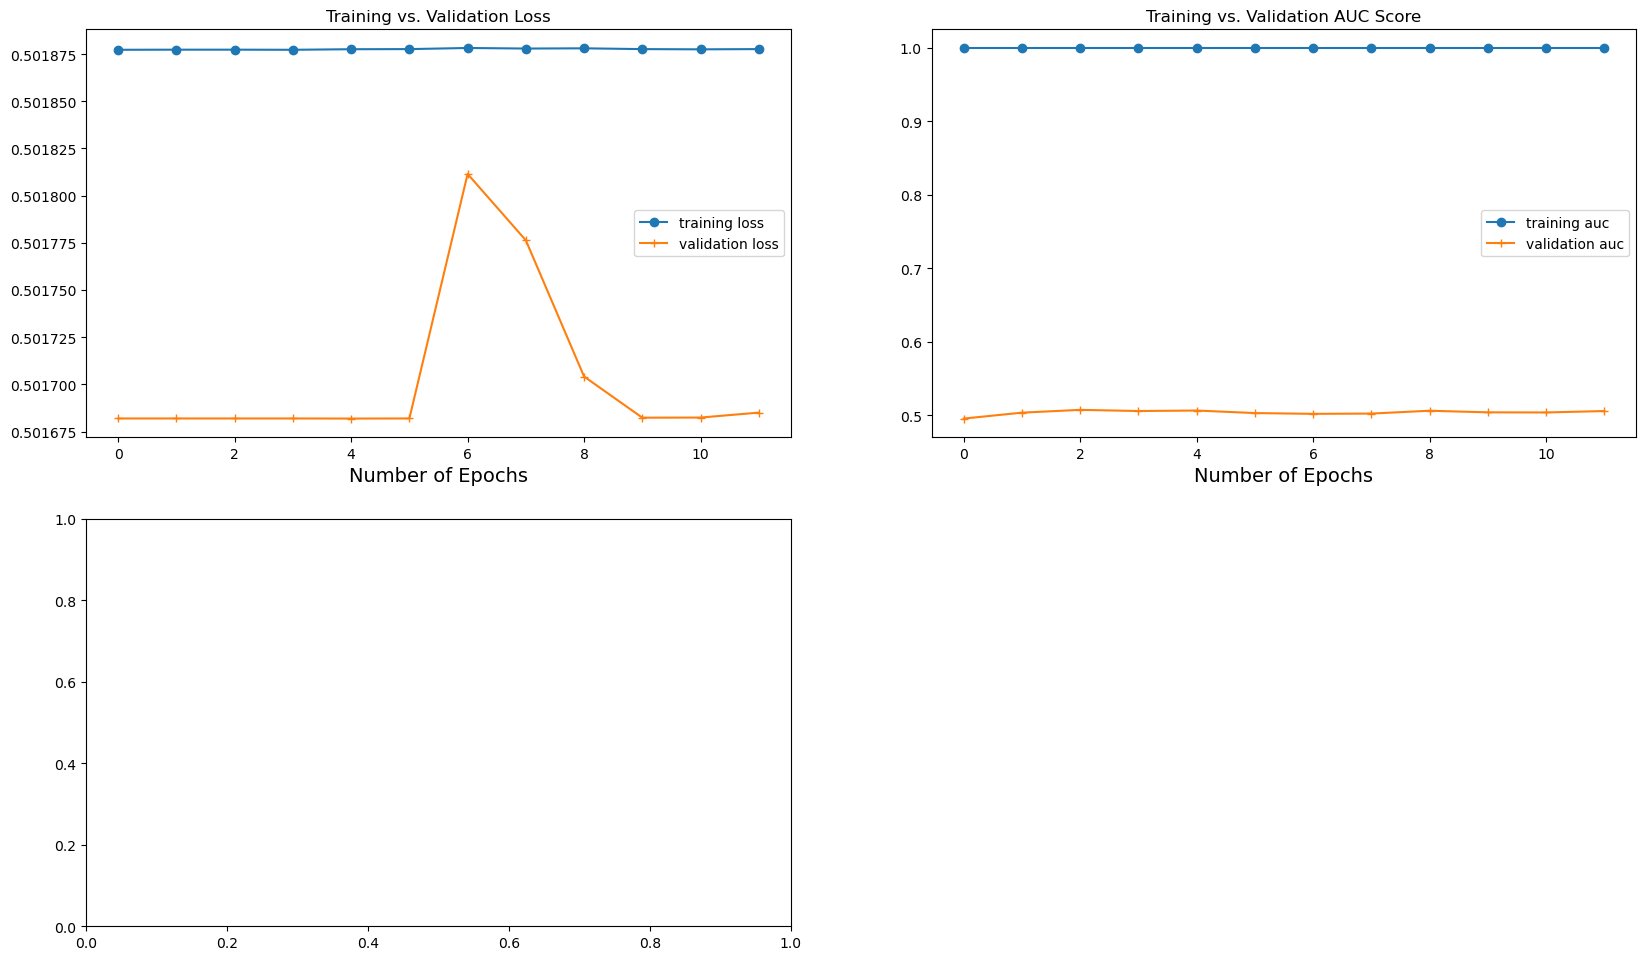

In [25]:
def create_charts(model, history, test_dataset, test_labels):
    # Define train & validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Define train & validation AUC
    train_auc_name = list(history.history.keys())[3]
    val_auc_name = list(history.history.keys())[1]
    train_auc = history.history[train_auc_name]
    val_auc = history.history[val_auc_name]
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']\
        
    # Predict on test data
    y_true = test_labels
    y_pred_prob = model.predict(test_dataset).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Plot
    plt.figure(figsize=(20, 18))
    
    # Plot 1: Train vs. Validation Loss 
    plt.subplot(3, 2, 1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss', marker='o')
    plt.plot(val_loss, label='validation loss', marker='+')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    # Plot 2: Train vs. Validation AUC
    plt.subplot(3, 2, 2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc', marker='o')
    plt.plot(val_auc, label='validation auc', marker='+')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    # Plot 3: Confusion Matrix
    plt.subplot(3, 2, 3)
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    ticklabels = ['Normal', 'Pneumonia']

    # Create confusion matrix as heatmap
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14)
    
    # Plot 4: ROC Curve
    plt.subplot(3, 2, 4)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc * 100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')

    ## PLOT 5: TRAIN VS. VALIDATION ACCURACY
    plt.subplot(3,2,5)
    plt.title("Training vs. Validation Accuracy")
    plt.plot(train_acc, label='training accuracy', marker='o')
    plt.plot(val_acc, label='validation accuracy', marker='+')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    # End plots
    plt.tight_layout()
    
    # Summary Statistics
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1 = 2 * precision * recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)
test = X_test[1:,:]
test_label = X_test[:1,:].flatten()
create_charts(autoencoder, history, test, test_label)